**Projet : Classification d'emails (spams ou hams)**

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence
import re
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (
    Input,
    SimpleRNN,
    Dense,
    Embedding,
    LSTM,
    Masking,
    Concatenate, Dot
)
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import LambdaCallback, History, EarlyStopping

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

Importation du jeu de données, et on regarde les différentes distributions

In [5]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/CMallart/ateliers-NN/main/data/spamorham/SPAM%20text%20message%2020170820%20-%20Data.csv"
)
data.head(n = 10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Caller...
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


In [6]:
data.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

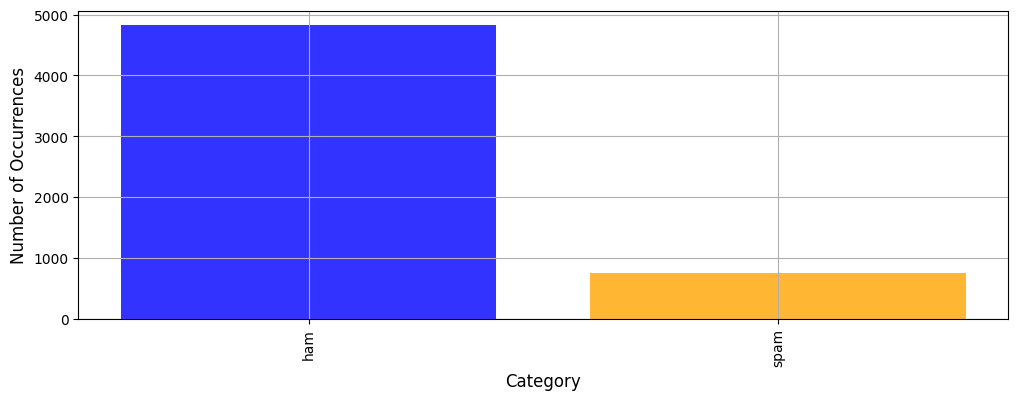

In [8]:
cnt_pro = data["Category"].value_counts()
plt.figure(figsize=(12, 4))
plt.bar(cnt_pro.index, cnt_pro.values, alpha=0.8, color=["blue", "orange"])
plt.ylabel("Number of Occurrences", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.xticks(rotation=90)
plt.grid()

On remarque d’emblée, que nos classes ham et spam sont déséquilibrés ce qui posera problème pour l’utilisation du modèle plus tard.En effet, si notre modèle retourne 100 % de ham, alors la précision serait à plus de 90% mais cela nous porterait préjudice car nous voulons aussi modéliser les spam

De plus, comme nos données sont basées sur du texte, voyons quel type de phrases apparaît dans notre base de données afin de cibler de la complexité du modèle

In [9]:
def see_message(ind):
    mess = data.iloc[ind]["Message"]
    print(mess)
    return mess


for message in [0, 15, 25, 35, 50]:
    see_message(message)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL
Just forced myself to eat a slice. I'm really not hungry tho. This sucks. Mark is getting worried. He knows I'm sick when I turn down pizza. Lol
Yup... Ok i go home look at the timings then i msg ü again... Xuhui going to learn on 2nd may too but her lesson is at 8am
What you thinked about me. First time you saw me in class.


In [10]:
# on vérifie il y a des chaînes vides, ou seulement des colonnes de ponctuation
# elles ne sont pas importantes ici, on les supprime
to_remove = []
for i, row in data.iterrows():
    if re.match(r".*[A-Za-z]+.*", row["Message"]) is None:
        print("'", row["Message"], "', at line", i)
        to_remove.append(i)
data = data.drop(to_remove, axis=0)
print("Removed the punctuation or numbers-only lines")

' 645 ', at line 1612
' :) ', at line 3376
' :-) :-) ', at line 4824
Removed the punctuation or numbers-only lines


In [11]:
def clean_text(text):
    # Retire le https://
    text = re.sub(r"http\S+", "", text)
    # Retire les urls
    text = re.sub(r"[^\s]*\.[a-z]{2,3}(\\|\?)*[^\s]*", "", text)
    return text


clean_text(see_message(15))

XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL


'XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>>  '

On transforme les données textuelles pour le rendre utilisable en tant qu'entrée d'un réseau de neurone.

L'ID 0 est réservé et n'est jamais utilisé.

Cette fonction comme son nom l’indique à deux buts, dans un premier temps, on va tokenizer nos messages, c’est-à-dire, on transforme l’ensemble des séquences en une suites de mots, dont ceux-ci sont codifiés.Cette tokenisation nous enlève les points de ponctuations, chaque split entre les mots devient un espace, si les mots ne sont pas reconnus, on les registre comme Out of Vocabulary

In [12]:
def tokenize_and_encode(text_data):
    # fit Tokenizer : from sequences of words to lists of numbers
    tokenizer = text.Tokenizer(
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        split=" ",
        oov_token="OUT_OF_VOCABULARY",
    )
    tokenizer.fit_on_texts(text_data)
    sequences = tokenizer.texts_to_sequences(text_data)
    ids = np.random.randint(0, len(text_data), size=3)
    for i in ids:
        print("For the input : ", text_data[i])
        print(" >>> tokenized output : ", sequences[i])
        print()

    # pad the data for input into the RNN
    # maxlen = max([len(x) for x in sequences])
    padded_sequences = sequence.pad_sequences(sequences, padding="post", maxlen=50)

    print("Number of Unique Tokens: %d" % len(tokenizer.word_index))
    return (padded_sequences, len(tokenizer.word_index) + 1, tokenizer)

On encode la donnée par un one hot encoding

In [13]:
# targets
# Binarize categories
targets = data["Category"].apply(lambda x: 0 if x == "spam" else 1).tolist()
one_hot_targets = np.eye(2)[targets]

# text
text_data, vocab_size, tokenizer = tokenize_and_encode(
    data["Message"].apply(clean_text)
)

For the input :  K come to nordstrom when you're done
 >>> tokenized output :  [116, 61, 3, 5545, 46, 258, 261]

For the input :  Ugh my leg hurts. Musta overdid it on mon.
 >>> tokenized output :  [503, 4220, 980, 28, 7, 33, 19, 2896]

For the input :  Hey next sun 1030 there's a basic yoga course... at bugis... We can go for that... Pilates intro next sat.... Tell me what time you r free
 >>> tokenized output :  [2, 104, 2, 62, 3751, 108, 95]

Number of Unique Tokens: 8820


On obtient avec notre tokenisation:8820 mots codifiés
Vu que nos mots ont désormais étaient codifiés, la deuxième partie de notre fonction encoding nous permet de transformer ces mots en chiffres pour qu’on puisse après appliquer nos modèles.Cela nous permet de mettre toutes nos séquences de mots dans une même dimension.Dans notre exemple à nous, la dimension est de 50, cela veut dire que si notre séquence de mots contient 5 mots, on remplira le vecteur de 45zéros.En d’autre termes, l’embedding consiste à représenter les mots par un vecteur de taille donnée, composé de 0 et 1 où la distance entre deux mots représente la représentation sémantique. Plus nos mots sont sémantiquement proches, plus la distancesera faible.C’est une méthode de faire des calculs sur les mots et de ne plus dépendre de leur représentation.Le pad_sequencesreprésente juste le remplissage des zéros si la séquence est trop courte ou la troncature si celle-ci est trop grande

In [14]:
# aperçu
for token, id_ in tokenizer.word_index.items():
    print(f"{token:10} >> id={id_}")
    if id_ == 10:
        break

OUT_OF_VOCABULARY >> id=1
i          >> id=2
to         >> id=3
you        >> id=4
a          >> id=5
the        >> id=6
u          >> id=7
and        >> id=8
in         >> id=9
is         >> id=10


In [16]:
# apercu donnée encodé
text_data

array([[  48,  464, 4333, ...,    0,    0,    0],
       [  50,  329, 1472, ...,    0,    0,    0],
       [  47,  480,    9, ...,    0,    0,    0],
       ...,
       [8818,   60,    9, ...,    0,    0,    0],
       [   6,  523,  113, ...,    0,    0,    0],
       [2638,   65,  458, ...,    0,    0,    0]], dtype=int32)

Echantillon train / test

In [17]:
X_train, X_test, y_train, y_test, mess_train, mess_valid = train_test_split(
    text_data,
    one_hot_targets,
    data["Message"].to_numpy(),
    test_size=0.33,
    random_state=17,
)

# On convertit en numpy pour l'entrée d'un RNN Keras
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Example of encoded train sequence: ", X_train[0])
print("Example of encoded target: ", y_train[0])

Example of encoded train sequence:  [   5 1293  277   13  565   65   25 4070    3 1444  184  758   36   32
  654  726   26 4071    7 4072  146   35  458    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Example of encoded target:  [0. 1.]


In [28]:
X_train.shape

(3731, 50)

In [19]:
# La longueur d'une séquence (phrase, ou série temporelle, etc.) est le pas de temps. Elle peut varier, mais nous avons choisi d'utiliser une longueur fixe. Pourquoi ?
# chaque entrée à chaque pas de temps ne représente qu'un seul nombre, elle est donc de taille 1
timestep = X_train[0].shape[
    0
]
n_features = 1

In [20]:
# Fonction outil pour la suite
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "acc" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "acc" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training accuracy ("
            + str(format(history.history[l][-1], ".5f"))
            + ")",
        )
    for l in val_acc_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation accuracy ("
            + str(format(history.history[l][-1], ".5f"))
            + ")",
        )

    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [21]:
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
    else:
        title = "Confusion matrix"

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


## multiclass ou binary report
## IF binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model, x, y_true, classes, batch_size=32, binary=False):

    # 2. Predict probabilities and stores in y_pred
    y_pred = model.predict(x, batch_size=batch_size)
    y_pred = y_pred.argmax(axis=1)
    y_true = y_true.argmax(axis=1)

    # 3. Print accuracy score
    print("Accuracy : " + str(accuracy_score(y_true, y_pred)))

    print("")

    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true, y_pred, digits=5))

    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix, classes=classes)

On se concentrer sur l'architecture RNN qu'on a vu précédemment. Construisons une couche d'intégration, puis une couche SimpleRNN (la couche de base). Cette couche ne retourne que le dernier état caché. Enfin, ajoutons une couche entièrement connectée adaptée à une prédiction

In [40]:
epochs = 25
batch_size = 16
lr = 0.5

In [42]:
# L'entrée de Keras pour tout réseau neuronal récurrent nécessite la forme suivante : (batch_size, timestep, n_features)
# batch_size peut être None, il sera entré au moment de la formation, c'est une valeur par défaut dans Keras si tous les timesteps sont égaux.
# timestep est la longueur de votre séquence
# n_features est le nombre de caractéristiques à chaque timestep. Si on avait réalisé un embedding pre-processing, ce nombre serait supérieur à 1.
input_ = Input(shape=(timestep))
e = Embedding(
    input_dim=vocab_size, output_dim=200, embeddings_initializer="zeros",mask_zero=True
)
embedding = e(input_)
rnn_layer = SimpleRNN(
    units=24, activation="sigmoid", recurrent_initializer="random_normal"
)(
    embedding
)  # in : size (None, timesteps, 64), out : size (None, units)
dense_layer = Dense(2, activation="softmax")(
    rnn_layer
)  # in : size(None, units), out : size(None, 2)
model_rnn = Model(input_, dense_layer)

si on met Mask Zero = True, alors, on ne calcule pas les séquences avec des 0 donc on ne pourra pas voir qu’une séquence est petite.Si on met Mask zero = False, on considérera l’entièreté de la longueur de la séquence.Le mask zero arrête le calcule s’il voit un zéro

On compile le modèle en introduisant un algorithme de descente de gradient stochastique, SGD.

In [43]:
# Output the model skeleton, and compile
model_rnn.summary()

optim = SGD(learning_rate=lr)
model_rnn.compile(
    optimizer=optim, loss="binary_crossentropy", metrics=["binary_accuracy"]
)

print_weights = LambdaCallback(
    on_epoch_end=lambda batch, logs: print(model_rnn.layers[1].get_weights())
)  # prints the 2nc layer's weights, ie the SimpleRNN's weghts
history = History()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 50, 200)           1764200   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 24)                5400      
                                                                 
 dense_3 (Dense)             (None, 2)                 50        
                                                                 
Total params: 1769650 (6.75 MB)
Trainable params: 1769650 (6.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
history = model_rnn.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_split=0.2,
    callbacks=[
        history,
        #        print_weights
    ],
)

Epoch 1/25
187/187 [==============================] - 9s 40ms/step - loss: 0.4214 - binary_accuracy: 0.8525 - val_loss: 0.3649 - val_binary_accuracy: 0.8809
Epoch 2/25
187/187 [==============================] - 9s 48ms/step - loss: 0.4161 - binary_accuracy: 0.8546 - val_loss: 0.3724 - val_binary_accuracy: 0.8809
Epoch 3/25
187/187 [==============================] - 7s 37ms/step - loss: 0.4147 - binary_accuracy: 0.8546 - val_loss: 0.3678 - val_binary_accuracy: 0.8809
Epoch 4/25
187/187 [==============================] - 9s 46ms/step - loss: 0.4101 - binary_accuracy: 0.8546 - val_loss: 0.3663 - val_binary_accuracy: 0.8809
Epoch 5/25
187/187 [==============================] - 9s 46ms/step - loss: 0.3964 - binary_accuracy: 0.8546 - val_loss: 0.3403 - val_binary_accuracy: 0.8809
Epoch 6/25
187/187 [==============================] - 7s 39ms/step - loss: 0.3551 - binary_accuracy: 0.8586 - val_loss: 0.3022 - val_binary_accuracy: 0.9023
Epoch 7/25
187/187 [==============================] - 9s 4

On regarde les résultats, courbe loss et accuracy, ainsi que la matrice de confusion

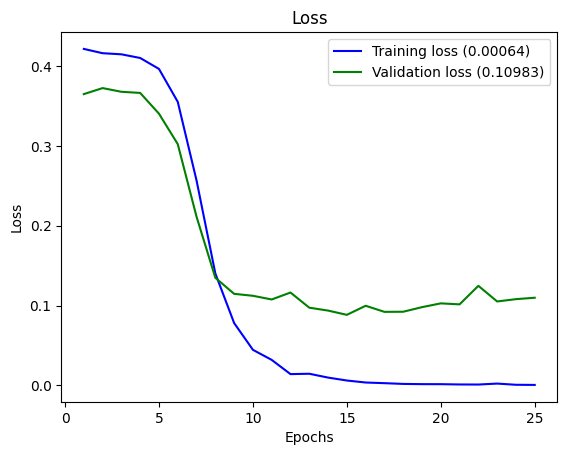

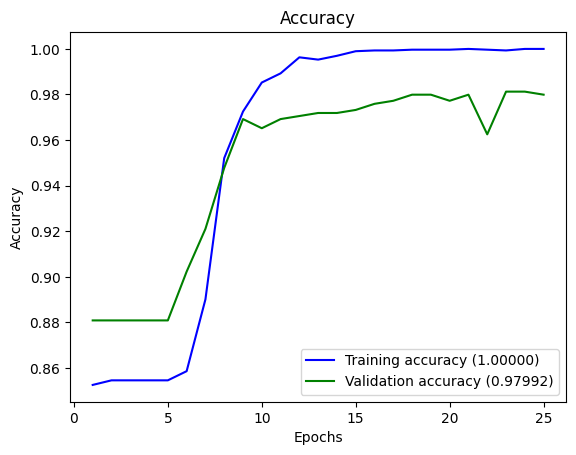

In [45]:
plot_history(history)

58/58 [==============================] - 1s 8ms/step
Accuracy : 0.9738846572361263

Classification Report
              precision    recall  f1-score   support

           0    0.91905   0.86161   0.88940       224
           1    0.98096   0.98947   0.98519      1614

    accuracy                        0.97388      1838
   macro avg    0.95000   0.92554   0.93730      1838
weighted avg    0.97341   0.97388   0.97352      1838

[[ 193   31]
 [  17 1597]]


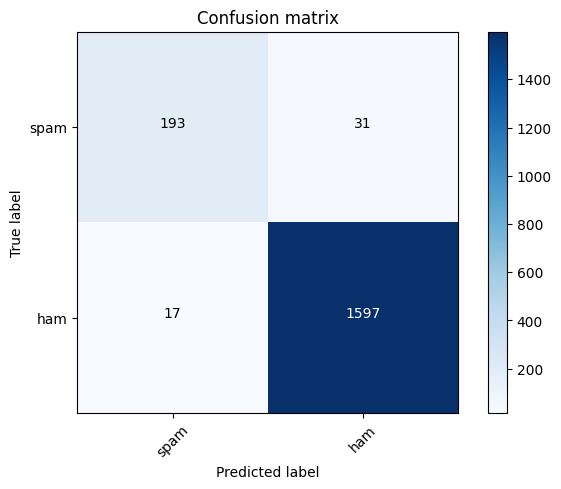

In [46]:
full_multiclass_report(model_rnn, X_test, y_test, ["spam", "ham"])

In [47]:
print("shape of padded tokenized input data:", X_train[0].shape)

shape of padded tokenized input data: (50,)


In [48]:
print("shape of embedded padded tokenized input data:", e(X_train[0]).shape)

shape of embedded padded tokenized input data: (50, 200)


In [49]:
print("textual data was << ", mess_train[0][:50], " [...] >>")
tokenized_data_sample = tokenizer.texts_to_sequences(mess_train[:1])[0]
print("tokenized textual data was:\n", tokenized_data_sample)

textual data was <<  A cute thought for friendship: "Its not necessary   [...] >>
tokenized textual data was:
 [5, 1293, 277, 13, 565, 65, 25, 4070, 3, 1444, 184, 758, 36, 32, 654, 726, 26, 4071, 7, 4072, 146, 35, 458]


In [50]:
# si on reconstruit via le tokenizer
for token_id in tokenized_data_sample:
    print(tokenizer.index_word[token_id], end=" ")

a cute thought for friendship its not necessary to share every secret with ur close frnd but watever u shared should be true 

In [51]:
e(X_train[:1])[0][0]

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([ 0.00556585,  0.01074981,  0.0034795 ,  0.00424075, -0.00204716,
       -0.00808817,  0.00388766,  0.00528575, -0.00474442, -0.00739328,
       -0.00124509, -0.00205777, -0.00437561,  0.00997249,  0.00820514,
        0.00227954, -0.00353396, -0.00955827,  0.00078826, -0.00253326,
       -0.00204177, -0.00572457,  0.00413689, -0.00233964,  0.00727457,
        0.00768813, -0.01389514,  0.00247866,  0.00871597,  0.00204874,
       -0.00041059,  0.01243554, -0.00149755,  0.00628358, -0.00375735,
        0.0028005 , -0.00984448,  0.01199602,  0.0081136 , -0.00297137,
        0.00510648,  0.00049608, -0.00254744, -0.00754957, -0.00037696,
       -0.00021321, -0.00675432, -0.00665099,  0.00289932, -0.00948231,
       -0.00231515,  0.00379322, -0.02104824, -0.00968607,  0.0014476 ,
        0.00218774, -0.00718757,  0.00882733,  0.00035313,  0.00381948,
        0.0039366 ,  0.00314962, -0.00327173, -0.00610769, -0.00444983,
        0.004809

Si On a un problème d’explosion de gradient, notre emodèle ne prédit que des ham.En apprentissage automatique, le problème du vanishing gradient est rencontré lors de la formation de réseaux neuronaux artificiels avec des méthodes d'apprentissage basées sur le gradient et la rétro-propagation. Dans ces méthodes, à chaque itération de la formation, chaque poids du réseau neuronal reçoit une mise à jour proportionnelle à la dérivée partielle de la fonction d'erreur par rapport au poids actuel.
En résumé, l’exploding gradient est un problème où de grands gradients d'erreur s'accumulent et entraînent des mises à jour très importantes des poids du modèle de réseau neuronal pendant la formation.

**On test le modèle LSTM**

L'architecture LSTM résout de nombreux problèmes des RNN de base, en particulier celui de l'explosion et du gradient de fuite. Elle permet également un contrôle plus fin de ce qui doit être conservé en mémoire dans le réseau.
L'architecture LSTM résout de nombreux problèmes des RNN de base, mais surtout celui de l'explosion et du gradient de fuite. Elle permet également un contrôle plus fin de ce qui doit ou ne doit pas être "mémorisé" dans le réseau.


Réinitialisons notre problème de classification des messages et utilisons une LSTM pour le résoudre - en utilisant des fonctions d'activation plus fines.

In [52]:
# hyperparametrees
epochs = 20
batch_size = 128
lr = 0.004

In [53]:
# architecture du modele
input_ = Input(shape=(timestep))
embedding = Embedding(input_dim=vocab_size, output_dim=200)(input_)
lstm_layer = LSTM(units=64, recurrent_activation="relu")(embedding)
dense_layer = Dense(2, activation="softmax")(lstm_layer)

model_lstm = Model(input_, dense_layer)

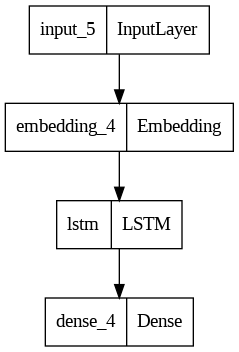

In [54]:
try:
    from keras.utils import plot_model
except ImportError:
    from keras.utils.vis_utils import plot_model

plot_model(model_lstm)

In [55]:
# compilation
optim = Adam(learning_rate=lr)#, clipvalue=1)
model_lstm.compile(
    optimizer=optim, loss="binary_crossentropy", metrics=["binary_accuracy"]
)
history = History()

In [56]:
history = model_lstm.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_split=0.2,
    callbacks=[history],
)

Epoch 1/20
24/24 [==============================] - 8s 236ms/step - loss: 0.4470 - binary_accuracy: 0.8274 - val_loss: 0.1599 - val_binary_accuracy: 0.9732
Epoch 2/20
24/24 [==============================] - 7s 280ms/step - loss: 0.1052 - binary_accuracy: 0.9742 - val_loss: 0.0797 - val_binary_accuracy: 0.9759
Epoch 3/20
24/24 [==============================] - 5s 209ms/step - loss: nan - binary_accuracy: 0.9330 - val_loss: nan - val_binary_accuracy: 0.5000
Epoch 4/20
24/24 [==============================] - 4s 157ms/step - loss: nan - binary_accuracy: 0.5000 - val_loss: nan - val_binary_accuracy: 0.5000
Epoch 5/20
24/24 [==============================] - 5s 231ms/step - loss: nan - binary_accuracy: 0.5000 - val_loss: nan - val_binary_accuracy: 0.5000
Epoch 6/20
24/24 [==============================] - 4s 153ms/step - loss: nan - binary_accuracy: 0.5000 - val_loss: nan - val_binary_accuracy: 0.5000
Epoch 7/20
24/24 [==============================] - 4s 160ms/step - loss: nan - binary_a

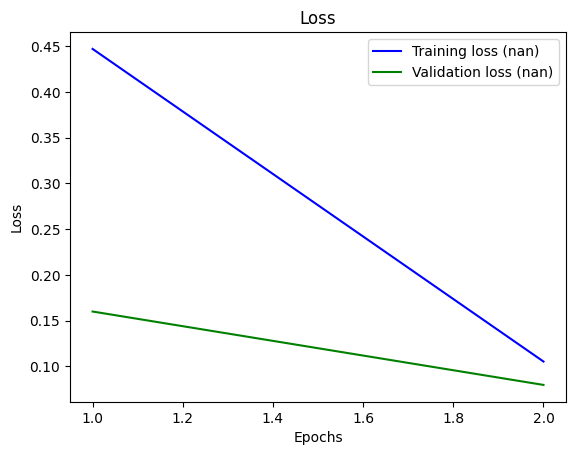

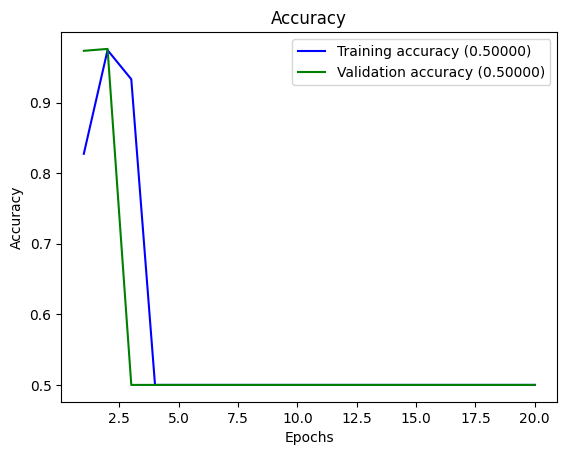

58/58 [==============================] - 2s 30ms/step
Accuracy : 0.12187159956474429

Classification Report
              precision    recall  f1-score   support

           0    0.12187   1.00000   0.21726       224
           1    0.00000   0.00000   0.00000      1614

    accuracy                        0.12187      1838
   macro avg    0.06094   0.50000   0.10863      1838
weighted avg    0.01485   0.12187   0.02648      1838

[[ 224    0]
 [1614    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


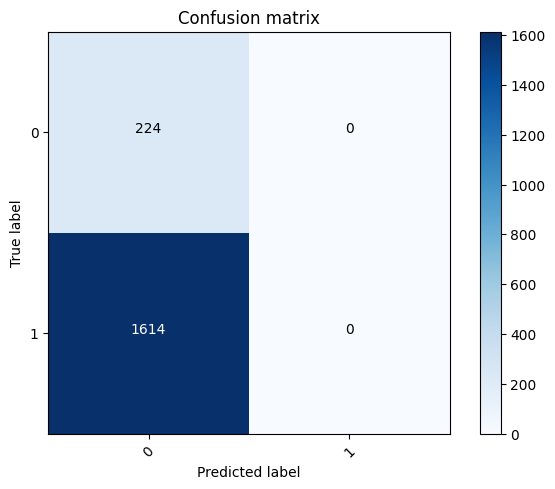

In [57]:
plot_history(history)
full_multiclass_report(model_lstm, X_test, y_test, [0, 1])

On a prédit intégralement les spams, cependant pour les hams notre prédiction est mauvaise.Le problème des réseaux de neurones est qu’ils ne varient pas assez.
Dans un tel cas, il faudrait modifier le learning rate, changez la fonction d’activation sigmoid, ajouter des couches de normalisation, ou utiliser le mask pour varier lesrésultats de notre réseau LSTM afin de trouver s’il y a des axes d’améliorations

**On souhaite maintenant utiliser le méchanisme d'attention**

On va utiliser une attention many-to-one : les entrées de la couche sont les sorties de la LSTM et nous voulons les utiliser uniquement pour prédire la dernière sortie, puisque nous faisons de la classification. Si la tâche était différente, par exemple la traduction, la couche serait différente.


Keras intègre également les couches d'attention de Luong et Badanau .Nous n'utiliserons pas ces couches Keras pour souligner que ces couches sont des opérations mathématiques que nous pouvons réimplémenter nous-mêmes grâce à quelques opérations Keras.

In [58]:
from keras.layers import dot, Activation, concatenate

In [59]:
# hyperparametres
epochs = 20
batch_size = 128
lr = 0.04

In [60]:
# Luong attention model

input = Input(shape=(timestep))
embedding = Embedding(input_dim=vocab_size, output_dim=200, mask_zero=True)(input)
(lstm_seq, h_t, state_c) = LSTM(
    units=128, recurrent_activation="relu", return_sequences=True, return_state=True
)(embedding)

# Compute scores for h_t
units = int(h_t.shape[1])
score_first_part = Dense(units, name="attention_score_part_1")(
    lstm_seq
)  # that is the W*h_s_bar in the slides' equations
score = dot(
    [score_first_part, h_t], [2, 1], name="attention_score"
)  # that is the h_t*W*h_s_bar in the slides' equations

# compute attention weights
attention_weights = Activation("softmax", name="attention_weights")(score)

# The context vector is the dot product between attention vector and the LSTM's hidden state
context_vector = dot([attention_weights, lstm_seq], [1, 1], name="context_vector")

# The attention vector is then obtained by concatenating the context vector to h_t and forwarding it through a tanh
concat_att_state = concatenate([context_vector, h_t])
attention_vector = Dense(
    64, use_bias=False, activation="tanh", name="attention_vector"
)(concat_att_state)

dense_layer = Dense(2, activation="relu", name="output")(attention_vector)
model_att = Model(inputs=input, outputs=dense_layer)

Comme vous l'avez certainement remarqué depuis le début, nous utilisons l'API fonctionnelle de Keras. Cela permet de choisir des couches individuelles et leurs sorties, de réutiliser les sorties et d'avoir des modèles multi-sorties. Nous pouvons donc utiliser lstm_seq

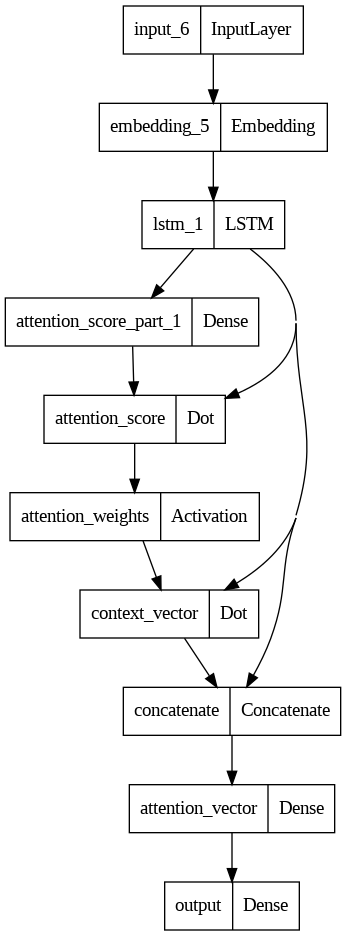

In [61]:
plot_model(model_att)

In [62]:
model_att.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 50, 200)              1764200   ['input_6[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               [(None, 50, 128),            168448    ['embedding_5[0][0]']         
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                            

Let's try to visualize attention. To achieve this we need attention's weights. We'll use a trick allowed by the functionnal API. Lets build a model `a_w_model`, standing for *attention weight model*, initialize it with the same layers than `model_att`. It's not only an initialization with `model_att`'s *values*, but it's the same *objects*, thus the very same layers that are shared across models.

Doing this, training `model_att` will provoke the same weight changes in `a_w_model`. The output of the latter is the "attention weight" of `model_att`, thus we just need to forward something into `a_w_model` to be able to analyze the attention weights

In [63]:
# model for attention weights, share the exact same layers as our main model
a_w_model = Model(
    inputs=model_att.inputs, outputs=model_att.get_layer("attention_weights").output
)

Let's use a callback to visualize attention's weights after each epoch.

In [64]:
from tensorflow.keras.callbacks import Callback

# to visualise, we use the great boutny of keras' functional model.
# we create our model that gets trained. And then on the side, we create another model, that shares exactly the same layers, but stops at the attention layer
# the first model will train, and because they share layers, the layers of the visu model will also train
# it suffices to get the output of the visu model to get the attention weights of the trained model

class VisualiseAttentionMap(Callback):
    def __init__(self, attention_weights_model, x_test, max_epochs, output_dir=None):
        super(Callback, self).__init__()
        self.visu_model = attention_weights_model
        # best_weights to store the weights at which the minimum loss occurs.
        self.x_test = x_test
        self.output_dir = output_dir
        self.max_epoch = max_epochs

    def on_epoch_end(self, epoch, logs=None):
        attention_map = self.visu_model.predict(self.x_test)
        self.attention_map = attention_map
        # print(attetion_map.shape)
        # top is attention map.
        # bottom is ground truth.
        # plt.imshow(np.concatenate([attention_map, x_test_mask]), cmap='hot')

        plt.imshow(attention_map, cmap="hot")

        iteration_no = str(epoch).zfill(3)
        plt.axis("off")
        plt.title(f"Iteration {iteration_no} / {self.max_epoch}")
        if self.output_dir is not None:
            if not os.path.exists(self.output_dir):
                os.makedirs(self.output_dir)
            plt.savefig(f"{output_dir}/epoch_{iteration_no}.png")
        plt.show()

Compilation

In [65]:
optim = SGD(learning_rate=lr) #Adam(learning_rate=lr, clipnorm=1)
model_att.compile(
    optimizer=optim, loss="binary_crossentropy", metrics=["binary_accuracy"]
)

history = History()
# earlyStop = EarlyStopping(monitor = "val_binary_accuracy", patience = 4, restore_best_weights=True)
attmap = VisualiseAttentionMap(a_w_model, X_train[0:10], epochs)

Epoch 1/20
1/1 [==============================] - 0s 270ms/step


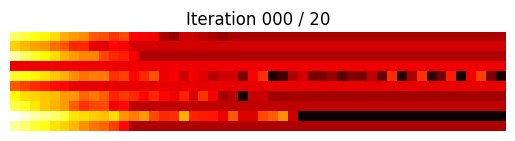

24/24 [==============================] - 16s 519ms/step - loss: 7.5711 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 60ms/step


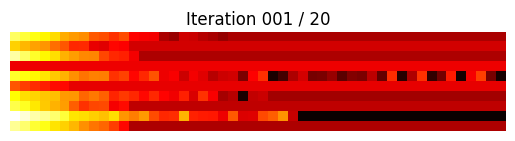

24/24 [==============================] - 9s 362ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 0s 39ms/step


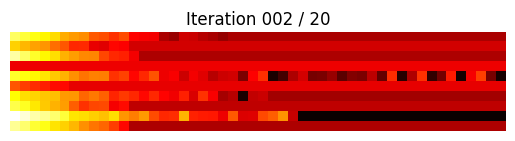

24/24 [==============================] - 7s 286ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 69ms/step


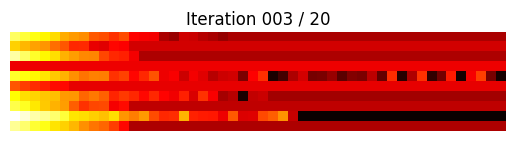

24/24 [==============================] - 10s 439ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 0s 41ms/step


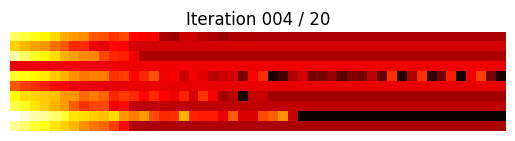

24/24 [==============================] - 8s 337ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 0s 38ms/step


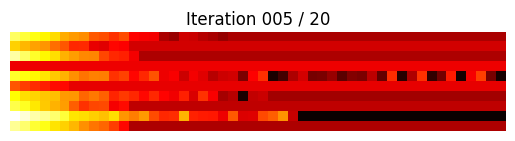

24/24 [==============================] - 9s 356ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 0s 73ms/step


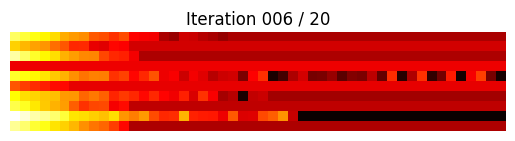

24/24 [==============================] - 8s 353ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 8/20
1/1 [==============================] - 0s 43ms/step


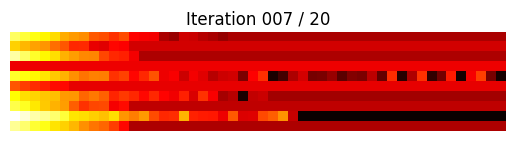

24/24 [==============================] - 7s 288ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 9/20
1/1 [==============================] - 0s 49ms/step


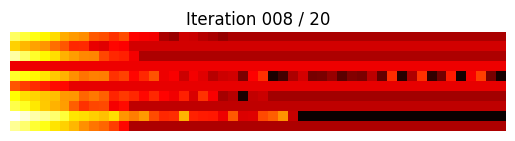

24/24 [==============================] - 9s 374ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 10/20
1/1 [==============================] - 0s 43ms/step


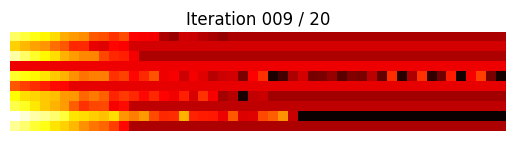

24/24 [==============================] - 7s 293ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 11/20
1/1 [==============================] - 0s 45ms/step


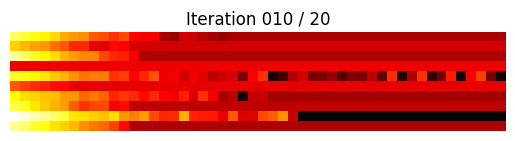

24/24 [==============================] - 9s 365ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 12/20
1/1 [==============================] - 0s 69ms/step


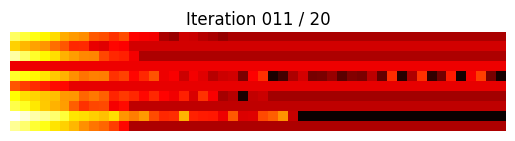

24/24 [==============================] - 7s 301ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 13/20
1/1 [==============================] - 0s 39ms/step


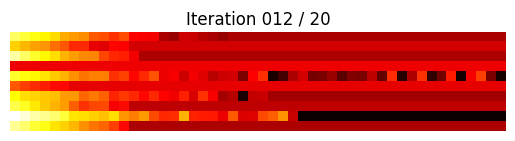

24/24 [==============================] - 8s 346ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 14/20
1/1 [==============================] - 0s 73ms/step


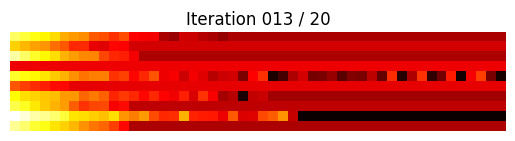

24/24 [==============================] - 9s 359ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 15/20
1/1 [==============================] - 0s 50ms/step


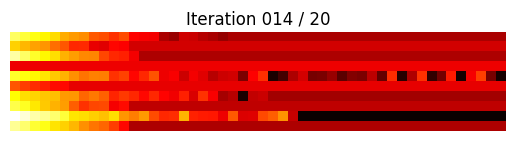

24/24 [==============================] - 7s 304ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 16/20
1/1 [==============================] - 0s 47ms/step


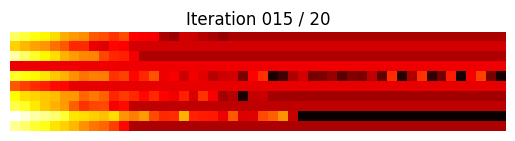

24/24 [==============================] - 9s 372ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 17/20
1/1 [==============================] - 0s 43ms/step


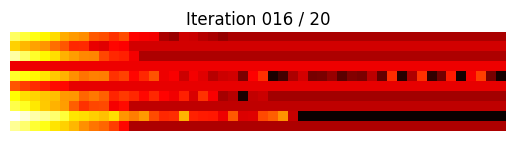

24/24 [==============================] - 7s 290ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 18/20
1/1 [==============================] - 0s 44ms/step


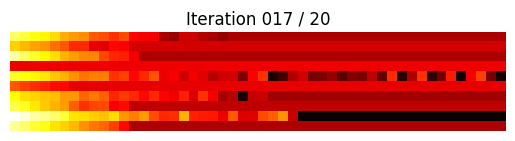

24/24 [==============================] - 9s 364ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 19/20
1/1 [==============================] - 0s 74ms/step


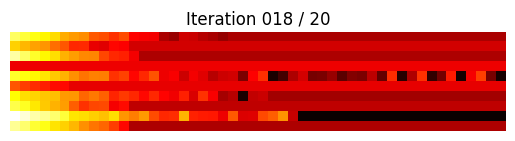

24/24 [==============================] - 7s 300ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 20/20
1/1 [==============================] - 0s 52ms/step


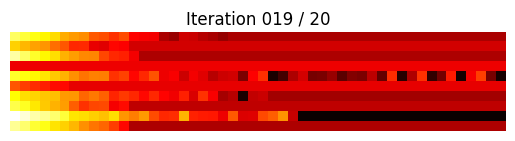

24/24 [==============================] - 8s 343ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000


In [66]:
model_att.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=128,
    verbose=1,
    validation_split=0.2,
    callbacks=[history, attmap],
)

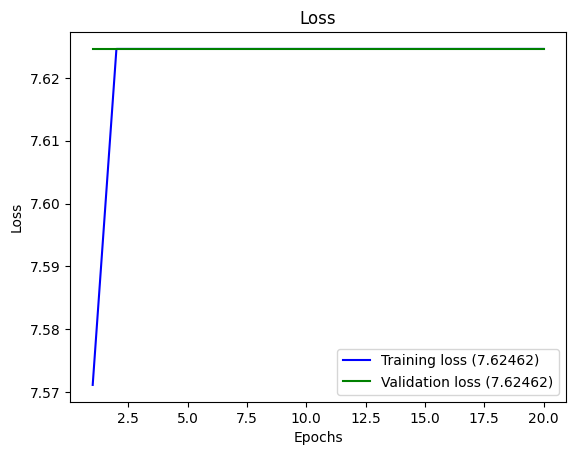

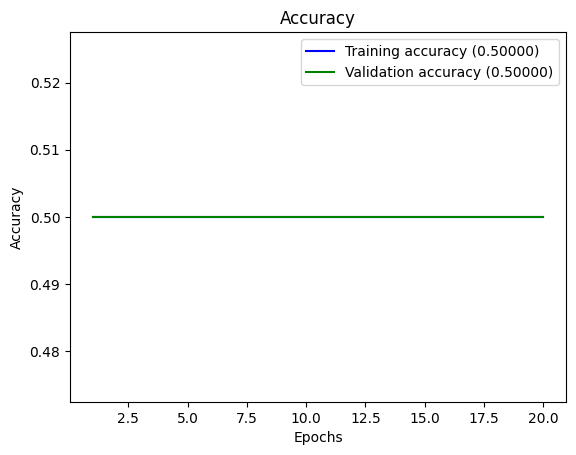

58/58 [==============================] - 3s 38ms/step
Accuracy : 0.8781284004352558

Classification Report
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       224
           1    0.87813   1.00000   0.93511      1614

    accuracy                        0.87813      1838
   macro avg    0.43906   0.50000   0.46756      1838
weighted avg    0.77111   0.87813   0.82115      1838

[[   0  224]
 [   0 1614]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


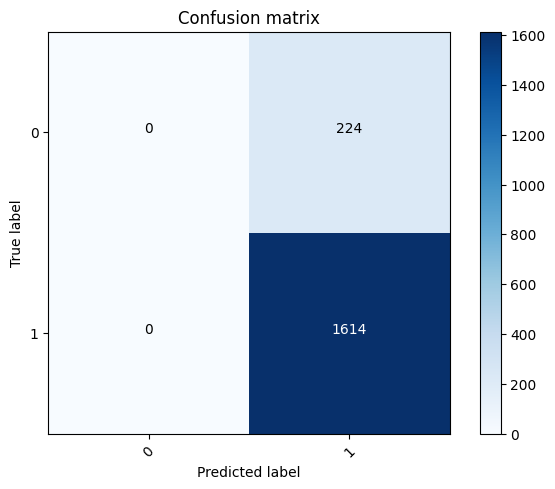

In [67]:
plot_history(history)
full_multiclass_report(model_att, X_test, y_test, [0, 1])

En effet, les problèmes sont toujours là mais moins immédiats.
Le LTSM permet de mitiger les problèmes de Vanishing Gradient, mais jusqu’à un certain point
seulement. Les problèmes étant plus long à apparaitre, on peut alors repérer plus facilement si on
est dans un cas de vanishing ou exploding gradient